In [2]:
import numpy as np
import matplotlib.pyplot as plt


epsilon0 = 55.26
freq_range = np.arange(50, 301, 1)


In [3]:

def thz_to_angular_frequency(thz_frequency):
    hz_frequency = thz_frequency * 1e12
    angular_frequency = 2 * np.pi * hz_frequency
    return angular_frequency
vthz_to_angular_frequency = np.vectorize(thz_to_angular_frequency)

In [4]:
plasma_frequency = 2200
plasma_ang_freq = thz_to_angular_frequency(plasma_frequency)
damping_frequency =  5.1987
damping_ang_freq = thz_to_angular_frequency(damping_frequency)
print(f"Frequency: {plasma_ang_freq} rad/s, Angular frequency: {damping_ang_freq} rad/s")
angular_frequencies= thz_to_angular_frequency(freq_range)

Frequency: 1.382300767579509e+16 rad/s, Angular frequency: 32664395456434.516 rad/s


In [13]:

def drude_permittivity(plasma_frequency, gamma, angular_frequencies):#Modelo de drude para la permitividad de la plata
    epsilon_values = np.zeros([251],dtype = 'complex_')
    for i,angular_frequency in enumerate(angular_frequencies):
        epsilon = (1 - (plasma_frequency**2 / (angular_frequency**2 + 1j * angular_frequency * gamma))) #Calculo de la permitividad relativa entre el vacio y la plata
        epsilon_values[i] =np.sqrt(np.conjugate(epsilon)* epsilon) # Calculo de la modulo de la permitividad relativa

    return epsilon_values


epsilon_r_values = drude_permittivity(plasma_ang_freq, damping_ang_freq, angular_frequencies)


In [6]:
def getKd(frecuencia, permitividad): #Calulo de del producto del numero de onda y el espesor de la placa de plata
    '''
    se usa la la raiz de la permitidad relativa que es ingual indice de refraccion de la plata n, por lo que hay que divide por la
    velocidad de la luz en metros y al calcular el espesor en metros se multiplica por (1/3) 10^(-15).
    '''
    K=frecuencia*np.sqrt(permitividad)*(1/3)*(10**(-15)) 
    return K

vgetKd= np.vectorize(getKd)

kd= vgetKd(angular_frequencies,epsilon_r_values)


[4.59411283+0.j 4.59454197+0.j 4.59494312+0.j 4.59531828+0.j
 4.59566926+0.j 4.59599773+0.j 4.5963052 +0.j 4.59659305+0.j
 4.59686254+0.j 4.59711484+0.j 4.59735101+0.j 4.59757203+0.j
 4.59777881+0.j 4.59797216+0.j 4.59815287+0.j 4.59832163+0.j
 4.59847912+0.j 4.59862593+0.j 4.59876262+0.j 4.59888973+0.j
 4.59900774+0.j 4.5991171 +0.j 4.59921824+0.j 4.59931154+0.j
 4.59939738+0.j 4.5994761 +0.j 4.59954802+0.j 4.59961344+0.j
 4.59967264+0.j 4.59972589+0.j 4.59977342+0.j 4.59981548+0.j
 4.59985229+0.j 4.59988404+0.j 4.59991093+0.j 4.59993315+0.j
 4.59995086+0.j 4.59996423+0.j 4.5999734 +0.j 4.59997853+0.j
 4.59997975+0.j 4.59997718+0.j 4.59997095+0.j 4.59996118+0.j
 4.59994798+0.j 4.59993144+0.j 4.59991166+0.j 4.59988875+0.j
 4.59986278+0.j 4.59983385+0.j 4.59980202+0.j 4.59976738+0.j
 4.59973001+0.j 4.59968996+0.j 4.5996473 +0.j 4.5996021 +0.j
 4.59955442+0.j 4.59950431+0.j 4.59945182+0.j 4.59939702+0.j
 4.59933994+0.j 4.59928063+0.j 4.59921914+0.j 4.59915552+0.j
 4.5990898 +0.j 4.599022

In [18]:
def P_1(kd):# Calculo de la matriz de propagacion de en la plata (medio 1)

    matrix = np.zeros([2,2], dtype='complex_')
    matrix[0][0]  = np.exp(-1j*kd)
    matrix[1][1] = np.exp(1j*kd)
    
    return matrix



In [19]:
def D_01(epsilon_r):# Calculo de la matriz de transmisión del vacio(medio 0) a la plata(medio 1)
    
    matrix = np.zeros([2,2], dtype='complex_')
    t_1_t = (np.sqrt(epsilon_r) +1)/2 # 1/t
    r = (np.sqrt(epsilon_r) - 1)/(np.sqrt(epsilon_r)+1)
    matrix[0][0] = t_1_t
    matrix[0][1] = r*t_1_t
    matrix[1][0] = r*t_1_t
    matrix[1][1] = t_1_t
        
    return matrix

In [20]:
def D_12(epsilon_r):# Calculo de la matriz de transmisión de la plata (medio 1) al vacio (medio 2)
    
    matrix = np.zeros([2,2], dtype='complex_')
    t_1_t = (np.sqrt(epsilon_r) +1)/(2*np.sqrt(epsilon_r) +1) # 1/t
    r = (1- np.sqrt(epsilon_r) )/(np.sqrt(epsilon_r)+1)
    matrix[0][0] = t_1_t
    matrix[0][1] = r*t_1_t
    matrix[1][0] = r*t_1_t
    matrix[1][1] = t_1_t
        
    return matrix

In [21]:
def getTransfermatrix(kds, epsilon_r_values): # Calculo de la matriz de transferencia total M = D_01*P_1*D_12 del punto 4
    matrices= list()
    for i in range(len(kds)):
        totalMatrix = np.matrix(D_01(epsilon_r_values[i]))*np.matrix(P_1(kds[i]))*np.matrix(D_12(epsilon_r_values[i]))
        matrices.append(totalMatrix)
    
    return matrices


Tmatrices= getTransfermatrix(kd, epsilon_r_values)



In [22]:
def TyR(Tmatrices): # Calculo de la transmitancia y la reflectancia t= 1/M_11 y r = M_21/M_11
    T = np.zeros([251],dtype="complex_")
    R = np.zeros([251],dtype="complex_")
    
    for i,m in enumerate(Tmatrices):
        T[i] = (1/m.item(0,0))*np.conjugate((1/m.item(0,0))) 
        R[i] = (m.item(1,0)/m.item(0,0))*np.conjugate((m.item(1,0)/m.item(0,0)))
    return R,T

R, T = TyR(Tmatrices)



print(np.mean(T+R)) # Calculo de la transmitancia y la reflectancia promedio
print(np.std(R+T)) # Calculo de la desviacion estandar de la transmitancia y la reflectancia promedio





(1.0031684184055152+0j)
0.0030408555580581473


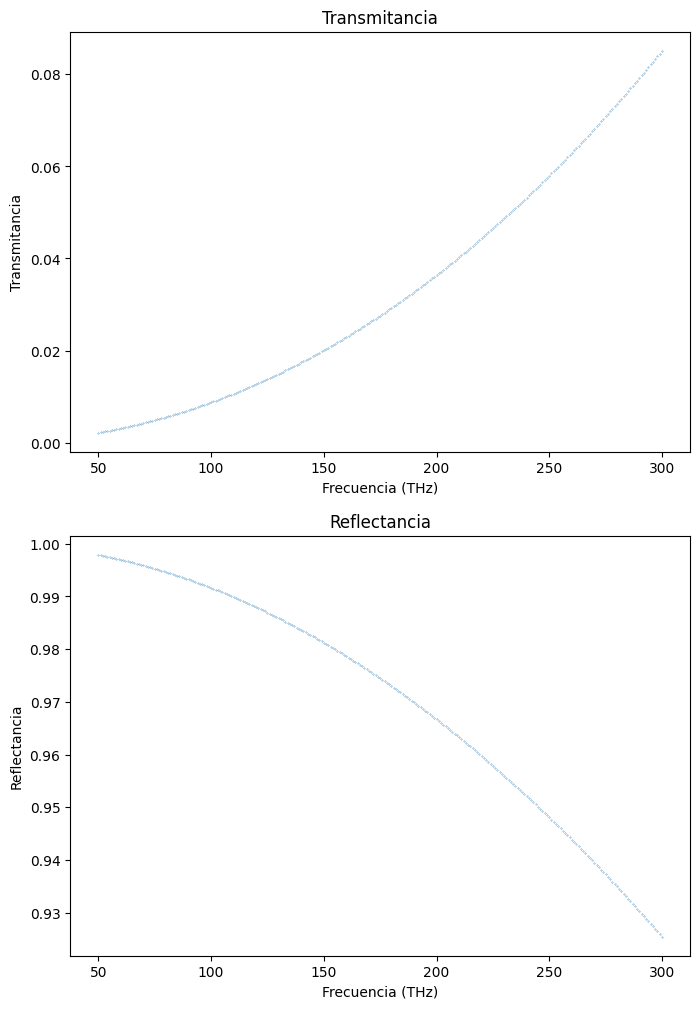

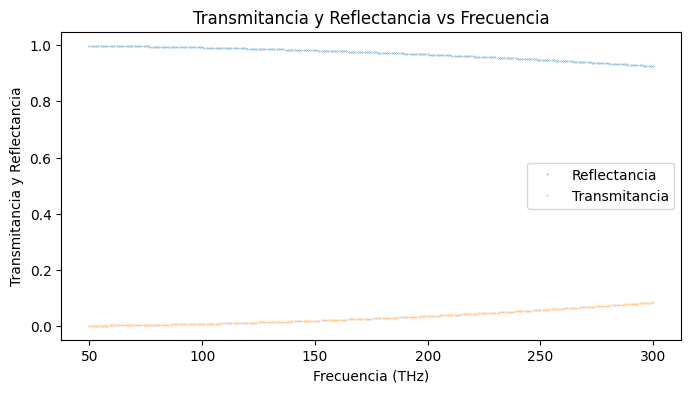

In [36]:
fig, ax2 = plt.subplots(2,1, figsize=(8 ,12))
ax2[0].plot(freq_range,T,'.', markersize=0.5)
ax2[1].plot(freq_range,R,'.', markersize=0.5)
ax2[0].set_title("Transmitancia")
ax2[1].set_title("Reflectancia")
ax2[0].set_xlabel("Frecuencia (THz)")
ax2[1].set_xlabel("Frecuencia (THz)")
ax2[0].set_ylabel("Transmitancia")
ax2[1].set_ylabel("Reflectancia")


plt.savefig("Graficas.png")
fig, ax3 = plt.subplots(1,1, figsize=(8,4))
ax3.plot(freq_range,R,'.', markersize=0.5, label="Reflectancia")
ax3.plot(freq_range,T,'.', markersize=0.5, label="Transmitancia")
ax3.set_title("Transmitancia y Reflectancia vs Frecuencia")
ax3.set_xlabel("Frecuencia (THz)")
ax3.set_ylabel("Transmitancia y Reflectancia")
ax3.legend()

plt.savefig("Graficas2.png")
